In [8]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import utils
import atari_wrappers
import matplotlib.pyplot as plt


from framebuffer import FrameBuffer
from experience_replay import ReplayBuffer

%matplotlib inline

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
seed = 228
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [11]:
ENV_NAME = "BreakoutNoFrameskip-v4"

env = atari_wrappers.make_env(env_name=ENV_NAME, seed=seed)
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

In [12]:
from models import DQNAgent
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [13]:
from experience_replay import make_experience_replay

exp_replay = make_experience_replay(env, agent, size=10**4)

buffer size = 10000, epsilon = 0.73450


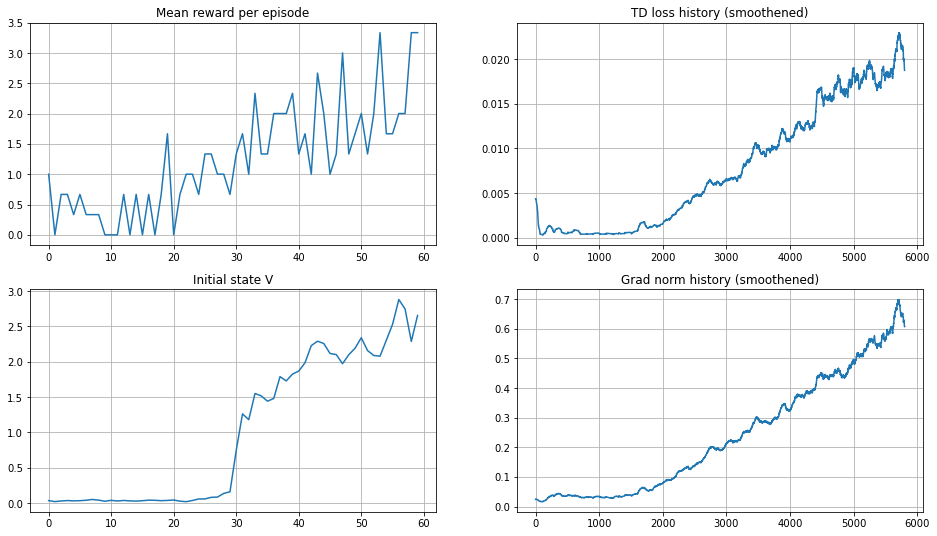

 15%|█▍        | 299992/2000001 [51:43<4:35:16, 102.93it/s] 

Stopping plotting to reduce training time.


 18%|█▊        | 369090/2000001 [1:03:33<4:26:59, 101.80it/s]

In [ ]:
from losses import compute_td_loss_double_q
from train import train

history = train(env, agent, target_network, exp_replay, compute_td_loss_double_q, device, batch_size=64, total_steps=2 * 10**6)

In [ ]:
plt.figure(figsize=[16, 9])
plt.subplot(2, 2, 1)
plt.title("Mean reward per episode")
plt.plot(history['reward_history'])
plt.grid()

assert not np.isnan(history['td_loss_history'][-1])
plt.subplot(2, 2, 2)
plt.title("TD loss history (smoothened)")
plt.plot(utils.smoothen(history['td_loss_history']))
plt.grid()

plt.subplot(2, 2, 3)
plt.title("Initial state V")
plt.plot(history['initial_state_v_history'])
plt.grid()

plt.subplot(2, 2, 4)
plt.title("Grad norm history (smoothened)")
plt.plot(utils.smoothen(history['grad_norm_history']))
plt.grid()

plt.show()

In [ ]:
torch.save(agent.state_dict(), "./models/double_dqn_bs64.pth")

Final scoring is done on a whole episode with all 5 lives.

In [ ]:
n_lives = 5

final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 10, 'not as cool as DQN can'
print('Cool!')

# Record a video

In [30]:
#agent.load_state_dict(torch.load("./models/double_dqn_bs64.pth"))

<All keys matched successfully>

In [31]:
# record sessions
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(), directory="videos", force=True)
sessions = [evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(10)]
env_monitor.close()